# Notebook for finetuning BERT

### The notebook is split up into the following sections:
1. Clean data
2. Split dataset into 80/20 split and tokenize
3. Pipeline and finetuning BERT
4. Evaluation metrics
5. Creating tables and confusion matrix for report 

In [72]:
# Import packages
import os
import json
import random
import re
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

# sklearn i
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy.stats import ttest_ind

# transformers 
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    set_seed
)

from datasets import Dataset
from tabulate import tabulate


# 1. Clean data

In [33]:
# loading in dataset
df = pd.read_csv("../Scraping/clean_reddit.csv")

In [34]:
# count
df["subreddit"].value_counts()

subreddit
CasualConversation    4044
depression            3864
Name: count, dtype: int64

### lets do a quick pronoun count

In [35]:
# First-person singular pronouns
FIRST_PERSON_PRONOUNS = {"i", "me", "my", "mine", "myself"}

# Count total number of first-person pronouns in a single post
def count_first_person(text):
    if not isinstance(text, str):
        return 0
    tokens = re.findall(r"\b\w+\b", text.lower())
    return sum(1 for t in tokens if t in FIRST_PERSON_PRONOUNS)

# Count each individual pronoun
def count_each_pronoun(text):
    if not isinstance(text, str):
        return Counter()
    tokens = re.findall(r"\b\w+\b", text.lower())
    return Counter(t for t in tokens if t in FIRST_PERSON_PRONOUNS)

# split by subreddit
df_dep = df[df["subreddit"] == "depression"]
df_ctrl = df[df["subreddit"] == "CasualConversation"]

# total and per-post counts 
def analyze_group(df_group, name):
    total_counter = Counter()
    per_post_counts = []

    for text in df_group["full_text"]:
        per_post_counts.append(count_first_person(text))
        total_counter.update(count_each_pronoun(text))

    print(f"\n========== {name.upper()} ==========")
    print("Total pronoun counts:", total_counter)
    print("Total posts:", len(df_group))
    print("Total pronouns:", sum(per_post_counts))
    print("Average per post:", sum(per_post_counts) / len(per_post_counts))
    print("Median per post:", sorted(per_post_counts)[len(per_post_counts)//2])

# Run analysis for both groups
analyze_group(df_dep, "Depression")
analyze_group(df_ctrl, "CasualConversation")


========== DEPRESSION ==========
Total pronoun counts: Counter({'i': 91360, 'my': 25372, 'me': 15784, 'myself': 4715, 'mine': 142})
Total posts: 3864
Total pronouns: 137373
Average per post: 35.55201863354037
Median per post: 26

========== CASUALCONVERSATION ==========
Total pronoun counts: Counter({'i': 28393, 'my': 8376, 'me': 4450, 'myself': 713, 'mine': 154})
Total posts: 4044
Total pronouns: 42086
Average per post: 10.40702274975272
Median per post: 7


### Lets look at the length of the posts from the dataset from r/depression

In [36]:
df_dep["char_len"] = df_dep["full_text"].str.len()
df_dep["char_len"].describe()

/var/folders/fg/lvd540x91w94plzyvtdb9rpw0000gn/T/ipykernel_45069/3604314048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dep["char_len"] = df_dep["full_text"].str.len()


count     3864.000000
mean      1543.149845
std       1548.748249
min         43.000000
25%        635.750000
50%       1103.000000
75%       1895.250000
max      18017.000000
Name: char_len, dtype: float64

### Lets look at the length of the posts from the dataset from r/CasualConversation

In [37]:
df_ctrl["char_len"] = df_ctrl["full_text"].str.len()
df_ctrl["char_len"].describe()

/var/folders/fg/lvd540x91w94plzyvtdb9rpw0000gn/T/ipykernel_45069/3401160515.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ctrl["char_len"] = df_ctrl["full_text"].str.len()


count    4044.000000
mean      748.936944
std       667.918083
min        80.000000
25%       347.000000
50%       542.000000
75%       915.000000
max      8676.000000
Name: char_len, dtype: float64

### Lets look at the max length from both datasets

In [38]:
idx = df_dep["full_text"].apply(count_first_person).nlargest(1).index
df_dep.loc[idx, "full_text"].values

array(['I\'m 18 and my life is a mess of regret. I need to get this off my chest...\n\nI don\'t even know where to begin. I\'m writing this because my mental health is in the gutter and I need to just put it all out there. Maybe someone can make sense of it, because I can\'t.\n\nI was born in April 2006 in Lansing, Michigan. I\'m a guy. Ever since I was young, I have always been into girls. Like, when I was in elementary school I used to, oh god... this is embarrassing... I would pretend I dropped something like a pencil or an eraser look under the table I was sat at to see under the girls\' skirts in my class. I know, it\'s disgusting.\n\nI grew up and had a good childhood. I was a chubby kid back then. Now, when I started highschool, I used to have no discipline and no sense of hygiene. I didn\'t take showers— only sometimes - like once a week or once every two weeks.\n\nI woke up, went to school, and didn\'t use the toilets in school since I hated them and thought they were disgusti

In [39]:
idx = df_ctrl["full_text"].apply(count_first_person).nlargest(1).index
df_ctrl.loc[idx, "full_text"].values

array(['Tips on how to find hobbies as a 22 year old female, plus me spilling other mumbo jumbo!\n\nHey yall, bit of a random post to make but it feels necessary and I need advice. I often feel stuck with my free time because I don’t have any time consuming hobbies. Sure, I enjoy to be crafty and creative and do set aside time to do things I enjoy such as making jewelry, thrifting, doing my makeup routine every morning, drawing, baking/cooking, etc. But… this stuff doesn’t isolate a large portion of my time everyday. I’m a very social motivated person, and my favorite thing to do is spend time with my finance and my friends. It’s hard because we don’t live together yet, so the concept of being within each other’s company even whilst doing separate things isn’t a reality yet. Aside from work, we spend almost all our free time together, which I absolutely adore. \n\nWhen I was younger, I really enjoyed video games. My fiancé (21m) still loves to play video games in his free time, which m

### I only keep relevant columns such as:

- ID
- full_text
- label

In [40]:
cols_to_drop = [
    "title", "selftext", "subreddit", "author",
    "created_utc", "created_dt", "score", "num_comments",
    "url", "link_flair_text", "source", "matched_keyword"
]

df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

In [41]:
# lets take a look at the final structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7908 entries, 0 to 7907
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         7908 non-null   object
 1   full_text  7908 non-null   object
 2   label      7908 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 185.5+ KB


# 2. Split data into 80/20 and tokenize

In [42]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,        # 20% validation
    stratify=df["label"], # mixing lavels
    random_state=42      
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))

Train size: 6326
Validation size: 1582


# Lets tokenize

In [43]:
# Loading in tokenizer
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [44]:
texts = train_df["full_text"].tolist()

enc = tokenizer(
    texts,
    padding=False,       # true lengths, no padding
    truncation=False,    # don't cut, we want full length
    add_special_tokens=True,
)

lengths = [len(ids) for ids in enc["input_ids"]]

print("Min length:", np.min(lengths))
print("Max length:", np.max(lengths))
print("Mean length:", np.mean(lengths))

print("\nPercentiles:")
for q in [50, 75, 90, 95, 99]:
    print(f"{q}th:", np.percentile(lengths, q))

# How many exceed BERT's 512-token limit?
over_512 = sum(l > 512 for l in lengths)
print("\n>512 tokens:", over_512, "out of", len(lengths),
      f"({over_512 / len(lengths) * 100:.2f}%)")


Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors


Min length: 9
Max length: 4401
Mean length: 270.08330698703764

Percentiles:
50th: 181.0
75th: 325.75
90th: 549.0
95th: 770.0
99th: 1530.25

>512 tokens: 732 out of 6326 (11.57%)


#### alright, so since 11% of the dataset is longer than the allowed tokens, we will chunk them later

In [45]:
MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

num_labels = 2  # depression vs casual
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
# convert from pd to huggingface df
train_hf = Dataset.from_pandas(train_df.reset_index(drop=True))
val_hf   = Dataset.from_pandas(val_df.reset_index(drop=True))

train_hf, val_hf

(Dataset({
     features: ['id', 'full_text', 'label'],
     num_rows: 6326
 }),
 Dataset({
     features: ['id', 'full_text', 'label'],
     num_rows: 1582
 }))

In [47]:
# tokenize and chunk
MAX_LENGTH = 512  

def tokenize_and_chunk(examples):
    enc = tokenizer(
        examples["full_text"],
        max_length=MAX_LENGTH,
        truncation=True,               # allow splitting into multiple chunks
        padding=False,                 # padding will be done later by data collator
        return_overflowing_tokens=True,
        return_length=True,
    )

    # Map each chunk back to its original example index
    overflow_mapping = enc["overflow_to_sample_mapping"]

    labels = []
    sample_ids = []
    for i in overflow_mapping:
        labels.append(examples["label"][i])
        if "id" in examples:
            sample_ids.append(examples["id"][i])
        else:
            sample_ids.append(i)  # fallback index if no id column

    enc["labels"] = labels
    enc["sample_id"] = sample_ids

    return enc

In [48]:
# alright now lets apply it to train and validation set
train_chunked = train_hf.map(
    tokenize_and_chunk,
    batched=True,
    remove_columns=train_hf.column_names,  
)

val_chunked = val_hf.map(
    tokenize_and_chunk,
    batched=True,
    remove_columns=val_hf.column_names,
)

train_chunked, val_chunked

Map:   0%|          | 0/6326 [00:00<?, ? examples/s]

Map:   0%|          | 0/1582 [00:00<?, ? examples/s]

(Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'length', 'overflow_to_sample_mapping', 'labels', 'sample_id'],
     num_rows: 7342
 }),
 Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'length', 'overflow_to_sample_mapping', 'labels', 'sample_id'],
     num_rows: 1837
 }))

In [49]:
# padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [50]:
#Lets take a look at the data
print(train_df["label"].value_counts())
print("\nProportions:")
print(train_df["label"].value_counts(normalize=True))


label
0    3235
1    3091
Name: count, dtype: int64

Proportions:
label
0    0.511382
1    0.488618
Name: proportion, dtype: float64


# 3. Pipeline and finetuning (Note: This chunk takes multiple hours to run)

I am fine-tuning three models with different hyperparameters to determine which one achieves the highest accuracy. The details for each model are as follows:

- **Model A**:
  - Learning Rate: `2e-5`
  - Epochs: `3`

- **Model B**:
  - Learning Rate: `2e-5`
  - Epochs: `4`

- **Model C**:
  - Learning Rate: `3e-5`
  - Epochs: `3`


In [ ]:
MODEL_NAME = "bert-base-uncased"

# these are metrics i want look at later (accuracy, precision, recall, F1)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds),
    }



# 2. Run one experiment + save model + metrics
def run_experiment(name: str, learning_rate: float, num_epochs: int):
    """
    Trains a fresh BERT model with given hyperparameters,
    evaluates on val_chunked, saves:
      - model in ./runs/{name}/best_model
      - eval metrics in ./runs/{name}/eval_results_final.json
    and returns the metrics dict.
    """
    print(f"\n===== Running experiment: {name} =====")
    print(f"lr={learning_rate}, epochs={num_epochs}")

    # fresh model for each run
    model = BertForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
    )

    out_dir = Path(f"./runs/{name}")

    # 3. defining training args
    training_args = TrainingArguments(
        output_dir=str(out_dir),
        learning_rate=learning_rate,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
        logging_steps=100,
        seed=42,
        # load_best_model_at_end here
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_chunked,
        eval_dataset=val_chunked,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    
    trainer.train()

    # Evaluate on validation set (one time, at the end) -
    metrics = trainer.evaluate()
    print(f"\nResults for {name}:")
    print(metrics)

    # lets check output dir exists 
    out_dir.mkdir(parents=True, exist_ok=True)

    # Save metrics to JSON 
    with open(out_dir / "eval_results_final.json", "w") as f:
        json.dump(metrics, f, indent=2)

    # Save the final model (treat as 'best')
    # This will create ./runs/{name}/best_model/ with config + weights + tokenizer
    trainer.save_model(out_dir / "best_model")

    return metrics

# 4. Run the three models (A, B, C)
results_default = run_experiment(
    name="bert_default_lr2e-5_ep3",
    learning_rate=2e-5,
    num_epochs=3,
)

results_tuned_epochs = run_experiment(
    name="bert_tuned_lr2e-5_ep4",
    learning_rate=2e-5,
    num_epochs=4,
)

results_tuned_lr = run_experiment(
    name="bert_tuned_lr3e-5_ep3",
    learning_rate=3e-5,
    num_epochs=3,
)

print("\nSummary of results:")
print("Model A (2e-5, 3 ep):", results_default)
print("Model B (2e-5, 4 ep):", results_tuned_epochs)
print("Model C (3e-5, 3 ep):", results_tuned_lr)


# 4. Evaluation metrics

In this section, I evaluate the performance of the models to assess potential overfitting. I compute several metrics, including accuracy, precision, recall, and F1 score, as well as confusion matrices for both the training and validation datasets.

In [73]:
# models
RUNS = {
    "Model A": "bert_default_lr2e-5_ep3",     
    "Model B": "bert_tuned_lr2e-5_ep4",        
    "Model C": "bert_tuned_lr3e-5_ep3",       
}

def eval_one_model(model_label: str, run_name: str):
    model_path = Path(f"./runs/{run_name}/best_model")
    if not model_path.exists():
        raise FileNotFoundError(f"Missing model path: {model_path}")

    model = BertForSequenceClassification.from_pretrained(model_path)

    eval_args = TrainingArguments(
        output_dir=f"./runs/{run_name}/eval_again",
        per_device_eval_batch_size=8,
        do_eval=True,
        do_predict=True,
        seed=42,
        report_to=[],  
    )

    trainer = Trainer(
        model=model,
        args=eval_args,
        train_dataset=train_chunked,
        eval_dataset=val_chunked,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    def score_split(name, ds):
        pred = trainer.predict(ds)
        y_true = pred.label_ids
        y_pred = pred.predictions.argmax(-1)
        metrics = {
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred),
            "recall": recall_score(y_true, y_pred),
            "f1": f1_score(y_true, y_pred),
        }
        cm = confusion_matrix(y_true, y_pred)
        return metrics, cm

    val_metrics, val_cm = score_split("val", val_chunked)
    train_metrics, train_cm = score_split("train", train_chunked)

    print(f"\n=== {model_label} ({run_name}) ===")
    print("Validation:")
    print(f"  accuracy : {val_metrics['accuracy']:.6f}")
    print(f"  precision: {val_metrics['precision']:.6f}")
    print(f"  recall   : {val_metrics['recall']:.6f}")
    print(f"  f1       : {val_metrics['f1']:.6f}")
    print(f"  CM (rows=true, cols=pred):\n{val_cm}")

    print("Train:")
    print(f"  accuracy : {train_metrics['accuracy']:.6f}")
    print(f"  precision: {train_metrics['precision']:.6f}")
    print(f"  recall   : {train_metrics['recall']:.6f}")
    print(f"  f1       : {train_metrics['f1']:.6f}")
    print(f"  CM (rows=true, cols=pred):\n{train_cm}")

# ---- run all ----
for label, run_name in RUNS.items():
    eval_one_model(label, run_name)


/var/folders/fg/lvd540x91w94plzyvtdb9rpw0000gn/T/ipykernel_45069/340426016.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/nadiahajighassem/Documents/GitHub/NLP_2025/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/nadiahajighassem/Documents/GitHub/NLP_2025/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



=== Model A (bert_default_lr2e-5_ep3) ===
Validation:
  accuracy : 0.985302
  precision: 0.983838
  recall   : 0.988832
  f1       : 0.986329
  CM (rows=true, cols=pred):
[[836  16]
 [ 11 974]]
Train:
  accuracy : 0.989785
  precision: 0.988494
  recall   : 0.992715
  f1       : 0.990600
  CM (rows=true, cols=pred):
[[3315   46]
 [  29 3952]]


/var/folders/fg/lvd540x91w94plzyvtdb9rpw0000gn/T/ipykernel_45069/340426016.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/nadiahajighassem/Documents/GitHub/NLP_2025/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/nadiahajighassem/Documents/GitHub/NLP_2025/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



=== Model B (bert_tuned_lr2e-5_ep4) ===
Validation:
  accuracy : 0.990201
  precision: 0.990863
  recall   : 0.990863
  f1       : 0.990863
  CM (rows=true, cols=pred):
[[843   9]
 [  9 976]]
Train:
  accuracy : 0.992509
  precision: 0.992721
  recall   : 0.993469
  f1       : 0.993095
  CM (rows=true, cols=pred):
[[3332   29]
 [  26 3955]]


/var/folders/fg/lvd540x91w94plzyvtdb9rpw0000gn/T/ipykernel_45069/340426016.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/nadiahajighassem/Documents/GitHub/NLP_2025/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/nadiahajighassem/Documents/GitHub/NLP_2025/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



=== Model C (bert_tuned_lr3e-5_ep3) ===
Validation:
  accuracy : 0.989657
  precision: 0.989858
  recall   : 0.990863
  f1       : 0.990360
  CM (rows=true, cols=pred):
[[842  10]
 [  9 976]]
Train:
  accuracy : 0.992509
  precision: 0.992968
  recall   : 0.993218
  f1       : 0.993093
  CM (rows=true, cols=pred):
[[3333   28]
 [  27 3954]]


### The metrics still look suspuciously high, lets see if the accruacy is as high for post level metrics and not chunking metrics for the model B (best model)

In [74]:
# really ensuring the same metric is computed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
set_seed(SEED)

# 1) model B

RUN_NAME = "bert_tuned_lr2e-5_ep4"   
run_dir = Path(f"./runs/{RUN_NAME}")

best_model_dir = run_dir / "best_model"

# If best_model doesn't exist, fall back to latest checkpoint in the run folder
if best_model_dir.exists():
    model_dir = best_model_dir
else:
    ckpts = sorted(
        run_dir.glob("checkpoint-*"),
        key=lambda p: int(p.name.split("-")[-1]) if p.name.split("-")[-1].isdigit() else -1
    )
    if len(ckpts) == 0:
        raise FileNotFoundError(
            f"Couldn't find a saved model for RUN_NAME='{RUN_NAME}'. "
            f"Looked for {best_model_dir} and {run_dir}/checkpoint-*. "
            "If you no longer have the runs/ folder, you’ll need to retrain or restore the checkpoint."
        )
    model_dir = ckpts[-1]

print("Loading model from:", model_dir)

# 2) Reload model + tokenizer
model = BertForSequenceClassification.from_pretrained(model_dir)
model.eval()  

tokenizer = AutoTokenizer.from_pretrained(model_dir)


# 3) Build a Trainer for prediction
eval_args = TrainingArguments(
    output_dir="./tmp_eval",
    per_device_eval_batch_size=16,
    do_train=False,
    do_eval=False,
    report_to=[],
    seed=SEED,
)

trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=val_chunked,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# 4) Chunk-level predictions
pred = trainer.predict(val_chunked)
logits = pred.predictions
chunk_labels = pred.label_ids
chunk_preds = np.argmax(logits, axis=1)

chunk_metrics = {
    "chunk_accuracy": accuracy_score(chunk_labels, chunk_preds),
    "chunk_precision": precision_score(chunk_labels, chunk_preds),
    "chunk_recall": recall_score(chunk_labels, chunk_preds),
    "chunk_f1": f1_score(chunk_labels, chunk_preds),
}
print("\nChunk-level metrics:", chunk_metrics)

# 4) Post-level aggregation via sample_id

sample_ids = np.array(val_chunked["sample_id"])

df = pd.DataFrame({
    "sample_id": sample_ids,
    "label": chunk_labels,
    "logit0": logits[:, 0],
    "logit1": logits[:, 1],
})

label_nunique = df.groupby("sample_id")["label"].nunique()
if (label_nunique > 1).any():
    bad = label_nunique[label_nunique > 1].index[:10].tolist()
    print("WARNING: Some sample_ids have mixed labels (showing up to 10):", bad)

post = df.groupby("sample_id", sort=False).agg(
    label=("label", "first"),
    logit0=("logit0", "mean"),
    logit1=("logit1", "mean"),
)

post_logits = post[["logit0", "logit1"]].to_numpy()
post_labels = post["label"].to_numpy()
post_preds = np.argmax(post_logits, axis=1)

post_metrics = {
    "post_accuracy": accuracy_score(post_labels, post_preds),
    "post_precision": precision_score(post_labels, post_preds),
    "post_recall": recall_score(post_labels, post_preds),
    "post_f1": f1_score(post_labels, post_preds),
}
print("\nPost-level metrics:", post_metrics)

print("\nPost-level confusion matrix (rows=true, cols=pred):")
print(confusion_matrix(post_labels, post_preds))

Loading model from: runs/bert_tuned_lr2e-5_ep4/best_model


/var/folders/fg/lvd540x91w94plzyvtdb9rpw0000gn/T/ipykernel_45069/3457465981.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/nadiahajighassem/Documents/GitHub/NLP_2025/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Chunk-level metrics: {'chunk_accuracy': 0.9902014153511159, 'chunk_precision': 0.9908629441624366, 'chunk_recall': 0.9908629441624366, 'chunk_f1': 0.9908629441624366}

Post-level metrics: {'post_accuracy': 0.9905183312262958, 'post_precision': 0.9884020618556701, 'post_recall': 0.9922380336351876, 'post_f1': 0.9903163331181407}

Post-level confusion matrix (rows=true, cols=pred):
[[800   9]
 [  6 767]]


In [75]:
train_pred = trainer.predict(train_chunked)
train_logits = train_pred.predictions
train_y = train_pred.label_ids
train_yhat = np.argmax(train_logits, axis=1)

train_acc = accuracy_score(train_y, train_yhat)
train_f1  = f1_score(train_y, train_yhat)

print("Train accuracy:", train_acc)
print("Train F1:", train_f1)

/Users/nadiahajighassem/Documents/GitHub/NLP_2025/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Train accuracy: 0.9925088531735222
Train F1: 0.9930947897049592


# 5. Tables and Confusion matrix for report

/var/folders/fg/lvd540x91w94plzyvtdb9rpw0000gn/T/ipykernel_45069/2845926242.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/nadiahajighassem/Documents/GitHub/NLP_2025/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


/var/folders/fg/lvd540x91w94plzyvtdb9rpw0000gn/T/ipykernel_45069/2845926242.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/nadiahajighassem/Documents/GitHub/NLP_2025/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


/var/folders/fg/lvd540x91w94plzyvtdb9rpw0000gn/T/ipykernel_45069/2845926242.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/nadiahajighassem/Documents/GitHub/NLP_2025/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Best model by validation F1: Model B


,Model,LR,Epochs,Val Accuracy,Val Precision,Val Recall,Val F1
0,Model A,2e-5,3,0.985,0.984,0.989,0.986
1,Model B,2e-5,4,0.990,0.991,0.991,0.991
2,Model C,3e-5,3,0.990,0.990,0.991,0.990


Saved: /Users/nadiahajighassem/Documents/GitHub/NLP_2025/results/model_metrics_table.md
Saved: /Users/nadiahajighassem/Documents/GitHub/NLP_2025/results/model_metrics_table.tex


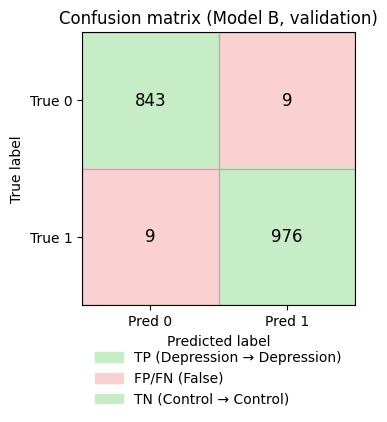

Saved: /Users/nadiahajighassem/Documents/GitHub/NLP_2025/results/figures/confusion_matrix_ModelB_val.png
Saved: /Users/nadiahajighassem/Documents/GitHub/NLP_2025/results/figures/confusion_matrix_ModelB_val.pdf


In [79]:
# all models
RUNS = {
    "Model A": {"run_name": "bert_default_lr2e-5_ep3", "lr": 2e-5, "epochs": 3},
    "Model B": {"run_name": "bert_tuned_lr2e-5_ep4",   "lr": 2e-5, "epochs": 4},
    "Model C": {"run_name": "bert_tuned_lr3e-5_ep3",   "lr": 3e-5, "epochs": 3},
}

INCLUDE_TRAIN = False  
OUT_DIR = Path("/Users/nadiahajighassem/Documents/GitHub/NLP_2025/results")
OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = OUT_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# METRICS
def compute_basic_metrics(y_true, y_pred):
    return {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred)),
        "recall": float(recall_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
    }

def eval_one_model(model_label: str, run_name: str):
    model_path = Path(f"./runs/{run_name}/best_model")
    if not model_path.exists():
        raise FileNotFoundError(f"Missing model path: {model_path}")

    model = BertForSequenceClassification.from_pretrained(model_path)

    eval_args = TrainingArguments(
        output_dir=str(OUT_DIR / f"tmp_eval_{run_name}"),
        per_device_eval_batch_size=8,
        do_predict=True,
        seed=42,
        report_to=[],
    )

    trainer = Trainer(
        model=model,
        args=eval_args,
        data_collator=data_collator,
        tokenizer=tokenizer,
    )

    # Validation
    val_pred = trainer.predict(val_chunked)
    y_val_true = val_pred.label_ids
    y_val_pred = val_pred.predictions.argmax(-1)
    val_metrics = compute_basic_metrics(y_val_true, y_val_pred)
    val_cm = confusion_matrix(y_val_true, y_val_pred)

    # Train 
    train_metrics, train_cm = None, None
    if INCLUDE_TRAIN:
        tr_pred = trainer.predict(train_chunked)
        y_tr_true = tr_pred.label_ids
        y_tr_pred = tr_pred.predictions.argmax(-1)
        train_metrics = compute_basic_metrics(y_tr_true, y_tr_pred)
        train_cm = confusion_matrix(y_tr_true, y_tr_pred)

    return val_metrics, val_cm, train_metrics, train_cm


# RUN EVALS + BUILD TABLE
rows = []
cms_val = {}   
cms_train = {} 

for label, meta in RUNS.items():
    run_name = meta["run_name"]
    lr = meta["lr"]
    epochs = meta["epochs"]

    val_metrics, val_cm, train_metrics, train_cm = eval_one_model(label, run_name)

    cms_val[label] = val_cm
    if INCLUDE_TRAIN and train_cm is not None:
        cms_train[label] = train_cm

    rows.append({
        "Model": label,
        "LR": f"{lr:.0e}".replace("e-0", "e-").replace("e+0", "e+"),  
        "Epochs": epochs,
        "Val Accuracy": val_metrics["accuracy"],
        "Val Precision": val_metrics["precision"],
        "Val Recall": val_metrics["recall"],
        "Val F1": val_metrics["f1"],
        **({
            "Train Accuracy": train_metrics["accuracy"],
            "Train Precision": train_metrics["precision"],
            "Train Recall": train_metrics["recall"],
            "Train F1": train_metrics["f1"],
        } if INCLUDE_TRAIN and train_metrics is not None else {})
    })

df = pd.DataFrame(rows)

# Choose best model by Val F1
best_row = df.iloc[df["Val F1"].idxmax()]
best_model = best_row["Model"]
best_cm = cms_val[best_model]

# Pretty formatting for display/export
df_pretty = df.copy()
for c in df_pretty.columns:
    if "Val " in c or "Train " in c:
        df_pretty[c] = df_pretty[c].map(lambda x: f"{x:.3f}")

print("Best model by validation F1:", best_model)
display(df_pretty)

# export
md_metrics_path = OUT_DIR / "model_metrics_table.md"
tex_metrics_path = OUT_DIR / "model_metrics_table.tex"

md_text = df_pretty.to_markdown(index=False)
tex_text = df_pretty.to_latex(index=False, escape=False)

md_metrics_path.write_text(md_text, encoding="utf-8")
tex_metrics_path.write_text(tex_text, encoding="utf-8")

print("Saved:", md_metrics_path)
print("Saved:", tex_metrics_path)


# Confusion Matrix with red and hreen

# Color assignment
colors = np.ones((2, 2, 4), dtype=float)  

# Soft colors (readable with black text)
light_green = np.array([0.78, 0.93, 0.78, 1.0])  
light_red   = np.array([0.98, 0.82, 0.82, 1.0])  
light_neutral = np.array([0.95, 0.95, 0.95, 1.0])  

# Color assignment
colors[1, 1] = light_green   # TP (true=1, pred=1)
colors[0, 1] = light_red     # FP (true=0, pred=1)
colors[1, 0] = light_red     # FN (true=1, pred=0)
colors[0, 0] = light_green   # TN (true=0, pred=0)

fig, ax = plt.subplots(figsize=(5.6, 4.4))
ax.imshow(colors, interpolation="nearest")

# Add counts on top
for (i, j), v in np.ndenumerate(best_cm):
    ax.text(j, i, str(v), ha="center", va="center", fontsize=12, color="black")

# Axis labels (make 0/1 meaning explicit)
ax.set_xticks([0, 1], labels=["Pred 0", "Pred 1"])
ax.set_yticks([0, 1], labels=["True 0", "True 1"])
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Confusion matrix ({best_model}, validation)")

# Light gridlines to separate cells
ax.set_xticks(np.arange(-.5, 2, 1), minor=True)
ax.set_yticks(np.arange(-.5, 2, 1), minor=True)
ax.grid(which="minor", linestyle="-", linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)

# Legend
legend_items = [
    mpatches.Patch(color=light_green, label="TP (Depression → Depression)"),
    mpatches.Patch(color=light_red, label="FP/FN (False)"),
    mpatches.Patch(color=light_green, label="TN (Control → Control)"),
]
ax.legend(handles=legend_items, loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=1, frameon=False)

plt.tight_layout()

# Save the figure as PNG and PDF
png_path = FIG_DIR / f"confusion_matrix_{best_model.replace(' ', '')}_val.png"
pdf_path = FIG_DIR / f"confusion_matrix_{best_model.replace(' ', '')}_val.pdf"
plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.savefig(pdf_path, bbox_inches="tight")
plt.show()

print("Saved:", png_path)
print("Saved:", pdf_path)
